In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shutil, os, random, gc, time, traceback
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras import backend as K

from keras.applications import InceptionV3, VGG16, ResNet50, InceptionResNetV2, DenseNet201

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.losses import binary_crossentropy

import cache_magic
%matplotlib inline

Using TensorFlow backend.


In [2]:
pd.options.display.float_format = "{:,.2f}".format

DATA_PATH = './data/'
MODEL_PATH = './model'

# DeepFashion: Versión reducida

En este notebook se realiza la comparativa entre un único modelo multietiqueta y un modelo compuesto por sub-modelos por tipo de atributo. 

Se emplea la versión reducida del conjunto de datos de DeepFashion. En análisis descriptivo de este conjunto de datos se realiza en un [Notebook anexo](./DeepFashion_VersionReducida_Analisis.ipynb). También se ha realizado [el mismo análisis](./DeepFashion_VersionCompleta_Analisis.ipynb) de la versión completa del dataset.

Para el particionado de datos en los conjuntos de entrenamiento, validación y test se emplean las particiones proporcionadas junto con el conjunto de datos. 

In [3]:
# Constantes

# Rutas a directorios de datos
ANNO_FINE_PATH = DATA_PATH + 'anno_fine'
TRAIN_PATH = ANNO_FINE_PATH + '/train'
VALIDATION_PATH = ANNO_FINE_PATH + '/val'
TEST_PATH = ANNO_FINE_PATH + '/test'
AUGMENTED_DATA_PATH = ANNO_FINE_PATH + '/augmented'
IMG = DATA_PATH + 'img'

# Rutas a ficheros de datos
ATTR_CLOTH_LIST_FILE = ANNO_FINE_PATH + '/list_attr_cloth.txt'
ATTR_IMG_LIST_FILE = ANNO_FINE_PATH + '/list_attr_img.txt'

# Constantes relativas al conjunto de datos
ATTR_TYPES = {'1':"Estampado",'2':"Tipo de manga",'3':"Forma",'4':"Tipo de cuello",'5':"Tejido",'6':"Tallaje"}
NUM_CLASSES = 26 


## 1. Lectura y preprocesado de datos

En primer lugar se crea una serie de estructuras de datos auxiliares para facilitar el trabajo con el dataset

In [4]:
# Lectura de la lista de atributos (fichero list_attr_cloth.txt)
def read_attr_cloth_list():
    column_to_attr_name = {}
    attr_type_to_columns = {}
    
    with open(ATTR_CLOTH_LIST_FILE) as fp: 
        fp.readline() # Ingorar numero de etiquetas
        fp.readline() # Ignorar cabecera
        column = 0
        for line in fp: 
            fields = line.split()
            attr = fields[0]
            attr_type = fields[1]
            column_to_attr_name[column] = attr
            if attr_type in attr_type_to_columns:
                attr_type_to_columns[attr_type].append(column)
            else:
                attr_type_to_columns[attr_type] = [column]
            column += 1
    return column_to_attr_name, attr_type_to_columns

In [5]:
# column_to_attr_name: Mapping número columna -> Nombre de atributo
# attr_type_to_columns: Mapping tipo de atributo - Lista de columnas de atributos de dicho tipo
column_to_attr_name, attr_type_to_columns = read_attr_cloth_list()           
# Listado con los nombre de los atributos
attributes = list(column_to_attr_name.values())

Extraemos las imágenes que forman parte de cada una de las paticiones, y las copiamos en un directorio con el nombre de la partición (test, val, train):

In [6]:
# Devuelve el listado de imágnes del fichero recibido como parámetro
def read_image_list(file_name):
    file_path = ANNO_FINE_PATH + '/' + file_name + '.txt'
    with open(file_path) as fp:
        return [DATA_PATH + img.rstrip('\n') for img in fp]
    
# Devuelve el path de la partición a partir del nombre de la partición
def build_partition_data_path(partition):
    return ANNO_FINE_PATH + '/' + partition

# Creación de la estructura de datos necesaria para los generadores de aumentación de datos
def create_data_structure(force=False):
    for partition in ['test', 'train', 'val']:
        partition_data_path = build_partition_data_path(partition)
        
        # Forzar recarga
        if os.path.exists(partition_data_path) and force:
            shutil.rmtree(partition_data_path)
        
        if not os.path.exists(partition_data_path):
            os.mkdir(partition_data_path)
            # Carga del listado de imágenes
            image_list = read_image_list(partition)
            # Copia
            for i, src in enumerate(image_list):
                dst = partition_data_path + '/' + str(i) + '.jpg' 
                shutil.copyfile(src, dst)


In [7]:
create_data_structure(False)

## 2. Aumentación de datos

A continuación se define la función que crea los generadores de imágenes, que realizan las transformaciones de data augmentation de forma dinámica en cada epoch del entrenamiento de los modelos. Se han configurado de forma que las imagenes generadas se almacenen en el directorio definidos por la constante AUGMENTED_DATA_PATH para poder ser inspeccionados. 

La función es parametrizable para poder realizar un análisis de los valores óptimos y elegir los más adecuados para esta tarea de clasificación. Este análisis se realiza más adelante.

In [8]:
# Construcción del dataframe requerido para usar la función flow_from_dataframe
def build_iterator_dataframe(partition, attr_type=None):
    partition_attribute_filepath = ANNO_FINE_PATH + "/" + partition + "_attr.txt"
    print(partition_attribute_filepath)
    data = pd.read_csv(partition_attribute_filepath, sep = ' ', names = attributes, index_col=False)
    
    # Filtrado por tipo de atributo. Empleado para los clasificadores separados por tipo de atributo. 
    if attr_type is not None:
        columns = attr_type_to_columns[str(attr_type)]
        fst, lst = columns[0], columns[-1]+1
        data = data.iloc[:, fst:lst]
    
    data['filename'] = [str(i) + '.jpg' for i in range(0,len(data))]
    
    return data

In [9]:
def get_attributes_for_attribute_type(attr_type):
    if attr_type is None:
        return attributes
    else:
        return [column_to_attr_name[c] for c in attr_type_to_columns[str(attr_type)]]

In [10]:
SEED = 1
BATCH_SIZE = 4


# Construcción del generador de datos de entrenamiento
def build_train_datagen(shear_range=0.025, zoom_range=0.025, rotation_range=2.5, fill_mode='nearest'):
    return ImageDataGenerator(
        rescale=1/255.0,
        shear_range=shear_range,
        zoom_range=zoom_range,
        rotation_range=rotation_range,
        fill_mode = fill_mode,
        horizontal_flip=True)

# Construcción de los generadores de datos de entrenamiento y validación
def build_generators(img_size, shear_range, zoom_range, rotation_range, fill_mode, attr_type = None):
        
    # Borrar los directorios con las imagenes generadas
    if os.path.exists(AUGMENTED_DATA_PATH):
        shutil.rmtree(AUGMENTED_DATA_PATH)
    os.mkdir(AUGMENTED_DATA_PATH)
    
    # Generator de entrenamiento
    train_datagen = build_train_datagen(shear_range, zoom_range, rotation_range, fill_mode)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe = build_iterator_dataframe('train', attr_type),
        x_col="filename",
        y_col=get_attributes_for_attribute_type(attr_type),
        directory=TRAIN_PATH,
        target_size=(img_size,img_size),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        color_mode='rgb',
        seed=SEED,
        save_to_dir=AUGMENTED_DATA_PATH
    )
    
    print(TRAIN_PATH)

    # Generator de validación
    validation_datagen = ImageDataGenerator(
         rescale=1./255
    )

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=build_iterator_dataframe('val', attr_type),
        x_col="filename",
        y_col=get_attributes_for_attribute_type(attr_type),
        directory=VALIDATION_PATH,
        target_size=(img_size,img_size),
        #batch_size=BATCH_SIZE,
        class_mode='raw',
        color_mode='rgb',
        seed=SEED
    )
    
    return train_generator, validation_generator


# Construcción del generador de datos de test
def build_test_generator(img_size=224, attr_type = None):
        
    test_datagen = ImageDataGenerator(
         rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=build_iterator_dataframe('test', attr_type),
        x_col="filename",
        y_col=get_attributes_for_attribute_type(attr_type),        
        directory=TEST_PATH,
        target_size=(img_size,img_size),
       # batch_size=BATCH_SIZE,
        class_mode=None,
        color_mode='rgb',
        seed=SEED,
        shuffle=False
    )
    
    return test_generator 

El siguiente código elige de forma aleatoria una imagen de la partición de test, y muestra 9 imagenes alteradas generadas con el código definido anteriormente. 

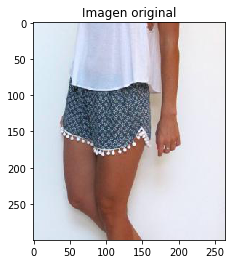

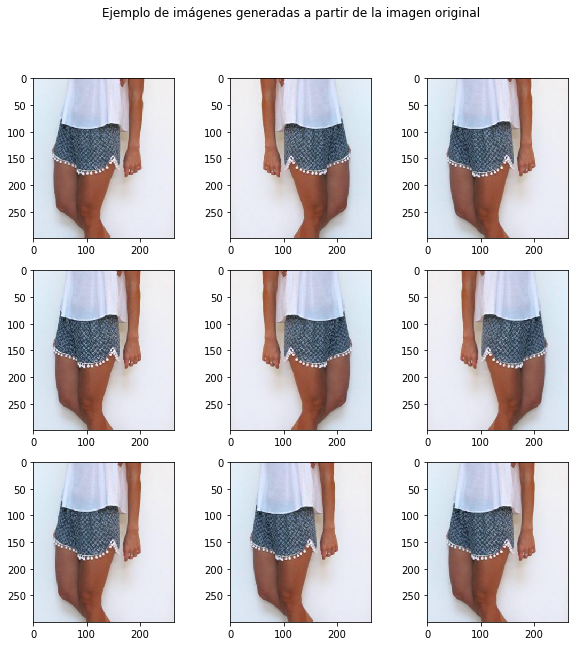

In [11]:
# Carga de una imagen aleatoria
path = ANNO_FINE_PATH + '/test'
file = random.choice(os.listdir(path))
img = load_img('{}/{}'.format(path, file))

plt.title('Imagen original')
plt.imshow(img)
plt.show()

# Preprocesado y preparación del iterador
data = img_to_array(img)
samples = np.expand_dims(data, 0)

generator = build_train_datagen()
it = generator.flow(samples, batch_size=1)

# Generación de 9 imágenes a partir de la imagen original
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Ejemplo de imágenes generadas a partir de la imagen original')
for x in range(9):
    batch = it.next()
    axs[x//3,x%3].imshow(batch[0], cmap='gray')
plt.show()

## 3. Automatización

Para poder probar distintos modelos de forma simple se define una función **_train_** que encapsula todo el código necesario para realizar el entrenamiento (limpieza de sesiones anteriores, instanciación del modelo y generadores de datos, etc...) 

Cabe destacar que se llama a la función fit con tres callbacks:
- Checkpoint, para persistir el modelo que minimiza el loss y poder ser empleado más adelante, en los casos en los que un modelo empiece a sobreajustar a los datos de entrenamiento. 
- Reducción de learning rate en el caso de que en N iteraciones seguidas el modelo no mejore. Viene definido por la constante LR_REDUCTION_PATIENCE. 
- Early stopping, para realizar la parada del entrenamiento en el caso de que no se consiga una mejora ni reduciendo la velocidad de aprendizaje. Viene definido por la constante EARLY_STOPPING_PATIENCE. 

Nótese que la función **_train_** requiere de dos parámetros obligatorios: model_name y model_id. Es primero es necesario porque, para realizar la instanciación del modelo se realiza una llamada una función con nombre **_build\_{model\_name}_**. El segundo parámetro es empleado a la hora de generar el nombre con el que persiste un modelo (**_model\_name\_model\_id.h5}_**) para poder persistir distintas versiones de un mismo tipo de modelo.

Esto permite que el código sea genérico y baste con definir una función **_build\_{model\_name}_** para poder entrenar y validar un modelo nuevo. 


In [12]:
# Definición de la función de loss empleada por defecto. 
# Detallado en la sección "Selección de función de loss"

import tensorflow as tf
import keras.backend.tensorflow_backend as tfb

POS_WEIGHT = 10  # multiplier for positive targets, needs to be tuned

def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.math.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=target,
                                                    logits=output,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)

In [13]:
EARLY_STOPPING_PATIENCE = 8
LR_REDUCTION_PATIENCE = 4

# Conversión del tamaño de la imagen al shape esperado como input del modelo
def to_input_shape(img_size):
    return (img_size,img_size,3)

# Construcción del path donde se persiste el modelo
def to_model_path(model_name, model_id, attr_type = None):
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    if attr_type is None:
        return '{}/{}_{}.h5'.format(MODEL_PATH, model_name, model_id)
    else:
        return '{}/{}_{}_{}.h5'.format(MODEL_PATH, model_name, model_id, attr_type)

# Construcción del nombre de la función de instanciación de un modelo
def to_build_function(model_name):
    return 'build_' + model_name

# Desactiva el entrenamiento del X% de capas iniciales. 
def freeze_layers(model, ratio=0.5):
    n_layers = len(model.layers)
    last_layer_to_freeze = int(n_layers*ratio)
    
    for layer in model.layers[:last_layer_to_freeze]:
        layer.trainable = False
    for layer in model.layers[last_layer_to_freeze:]:
        layer.trainable = True
    
    return model

def build_callbacks(model_name, model_id, store_model):
    callbacks = []
    # Parar la ejecución si el loss no disminuye en 3 iteraciones
    early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, verbose=1, min_delta=1e-4)
    callbacks.append(early_stopping)
    # Reducir el learning rate si el loss no disminuye en 3 iteraciones
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_REDUCTION_PATIENCE, verbose=1, min_delta=1e-4)  
    callbacks.append(reduce_lr)
    # Guardar el modelo que más disminuye el loss en fichero
    if store_model:
        checkpoint = ModelCheckpoint(filepath = to_model_path(model_name, model_id), 
                                     monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks.append(checkpoint)
    return callbacks

# Entrenamiento, y todo el pre-procesamiento necesario. 
def train(model_name,
          model_id=None,
          max_epochs=100, 
          img_size=224,
          shear_range=0.05, 
          zoom_range=0.150, 
          rotation_range=2.5, 
          fill_mode='constant',
          store_model=True,
          two_step_fit=False,
          freeze_layers_ratio=None,
          model_build_params=None,
          loss_function=weighted_binary_crossentropy,
          attr_type=None
         ):
    
    # Forzar limpieza y pasar el GC
    K.clear_session()
    #cuda.select_device(0)
    #cuda.close()
    gc.collect()
    
    # Instanciación del modelo. Todos los métodos siguen el patrón "build_xxx", donde xxx es esl nombre del modelo
    input_shape = to_input_shape(img_size)
    model = globals()[to_build_function(model_name)](input_shape, model_build_params)
    #model.summary()
    
    # COMPILE con run options para debug en caso de oom
    #run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss=loss_function, metrics=[tf.keras.metrics.AUC(name='auc')])
    
    # Instanciación de los generators de datos
    train_generator, validation_generator = build_generators(img_size, shear_range, 
                                                             zoom_range, rotation_range, fill_mode, attr_type)
    
    
    
    # FIT
    # Dependiendo de la complejidad del modelo, se hace fit una única vez, o dos veces para ajustar primero las últimas capas
    # y posteriormente el resto
    if two_step_fit:
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, False),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
        # Segunda fase de training para entrenar el resto de las capas
        model = freeze_layers(model, freeze_layers_ratio)
        model.compile(optimizer='adam', loss=loss_function, metrics=[tf.keras.metrics.AUC(name='auc')])
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, store_model),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
    else:
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, store_model),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
    
    return (h.history['val_loss'], h.history['val_auc'])

In [14]:
def plot(results, metric, legend_loc = 'upper right'):
    legend = []
    fig = plt.figure(figsize=(15,10))
    for k,v in results.items():
        plt.plot(v)
        legend.append(k)
    plt.title('Comparativa de ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(legend, loc=legend_loc)
    figsize=(10,8)
    plt.show()  

## 4. Optimización de hiperparámetros

Para la búsqueda de valores óptimos para distintos parámetros empleados por el proceso se empleará un modelo 'baseline'. Éste se basa en una arquitectura ResNet50 con función de activación sigmoide para permitir la clasificación multietiqueta. 

In [15]:
def build_baseline(a,b):
    base_model = ResNet50(
        include_top=True,
        weights="imagenet",
        input_shape=(224,224,3),
        pooling='max'
        )
    x = base_model.output
    x = Dense(64, activation="relu")(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

### 4.1 Tamaño de la imagen

De momento se obvia la comprobación de si el tamaño de la imagen influye en el resultado de clasificación

### 4.2 Parámetros de data augmentation

Vamos a comprobar como influyen los parámetros de data augmentation sobre el accuracy. Se trata de encontrar valores equilibrados puesto que valores muy bajos pueden causar que el modelo no sea capaz de generalizar correctamente, mientas que con valores muy altos se estén realizando transformaciones muy alejadas de la realidad de los datos. 

In [16]:
N = 25

def evaluate_data_augmentation_params():  
    results = pd.DataFrame(columns = ['shear_range','zoom_range', 'rotation_range', 'fill_mode', 'val_loss','val_auc'])
    for it in range(0,N):
        shear_range = random.choice([0.025, 0.05, 0.1, 0.15])
        zoom_range = random.choice([0.025, 0.05, 0.1, 0.15])
        rotation_range = random.choice([2.5, 5, 7.5])
        fill_mode = random.choice(["constant", "nearest", "wrap"]) # Ignoramos reflect
        print('Evaluation #{}'.format(it))
        (val_loss, val_auc) = train('baseline', it, store_model=False,
                                                           shear_range=shear_range, zoom_range=zoom_range, rotation_range=rotation_range,
                                                           fill_mode = fill_mode, img_size=224)
        results.loc[it] = [shear_range, zoom_range, rotation_range, fill_mode, min(val_loss), max(val_auc)]
    return results

In [17]:
%cache data_augmentation_results = evaluate_data_augmentation_params()
data_augmentation_results.sort_values(by='val_loss', ascending=True).head(n=10)

Loading cached value for variable 'data_augmentation_results'. Time since caching: 2 days, 20:42:32.927249


,shear_range,zoom_range,rotation_range,fill_mode,val_loss,val_top_k_categorical_accuracy
21,0.05,0.15,2.50,constant,0.35,0.50
11,0.05,0.10,5,wrap,0.35,0.47
13,0.03,0.05,2.50,wrap,0.35,0.44
1,0.10,0.15,2.50,constant,0.35,0.39
18,0.10,0.10,7.50,constant,0.35,0.45
17,0.10,0.15,7.50,nearest,0.35,0.48
7,0.05,0.03,5,nearest,0.35,0.50
20,0.10,0.05,7.50,constant,0.35,0.38
23,0.10,0.05,5,constant,0.35,0.48
24,0.05,0.15,7.50,constant,0.35,0.52


Se establece los valores que minimizan el valor de loss sobre el conjunto de validación como los valores por defecto a emplear en la aumentación de datos, y serán los que se usarán para el entrenamiento de los modelos de los siguientes apartados. 

### 4.3 Selección de función de loss

En pruebas realizadas con anterioridad se ha comprobado que el accuracy no es una buena métrica para este problema puesto que hasta con el modelo más simple se consiguen valores superiores al 80%. Esto se debe a que esta métrica es el promedio del número etiquetas predicho correctamente dividido entre el número total de etiquetas para cada una de las observaciones, tal y como se comenta en [aquí](https://stackoverflow.com/questions/50686217/keras-how-is-accuracy-calculated-for-multi-label-classification). En el caso de este dataset existen 26 clases, y cada observación está asociada a 6 valores positivos y a 20 negativos. Este alto número de valores negativos hace que se obtenga siempre un valor alto de accuracy, por lo que se ha optado por emplear el área bajo la curva ROC (AUC) puesto que se considera que esta métrica, al estar basada en la relación entre sensibilidad y especificidadad, se ajusta más al problema en cuestión. 

Por otro lado, se ha hecho una comparativa entre dos funciones de loss que se emplean comunmente para las clasificaciones multietiqueta: binary cross entropy y weighted binary crossentropy. El hecho de que por cada observación existan 20 etiquetas con valor 0 y 6 con valor 1 hace pensar que asignándole un peso superior al valor 1 se conseguirá un resultado mejor. 

Esta última función se encuentra disponible en Tensorflow pero no está adaptada para ser usada directamente desde Keras, por lo que se emplea el código publicado abiertamente en un artículo de [StackExchange](https://stats.stackexchange.com/questions/261128/neural-network-for-multi-label-classification-with-large-number-of-classes-outpu). El código se ha definido en el apartado anterior. 

Se entrena el modelo baseline empleando las dos funciones de loss, y se establece la comparativa.

In [18]:
RESET = False
if(RESET):
    %cache -r res_binary_crossentropy
    %cache -r res_weighed_crossentropy

%cache res_binary_crossentropy = train('baseline', loss_function=binary_crossentropy, store_model=False)
%cache res_weighed_crossentropy = train('baseline', loss_function=weighted_binary_crossentropy, store_model=False)

Loading cached value for variable 'res_binary_crossentropy'. Time since caching: 1:45:58.412572
Loading cached value for variable 'res_weighed_crossentropy'. Time since caching: 1:39:10.412885


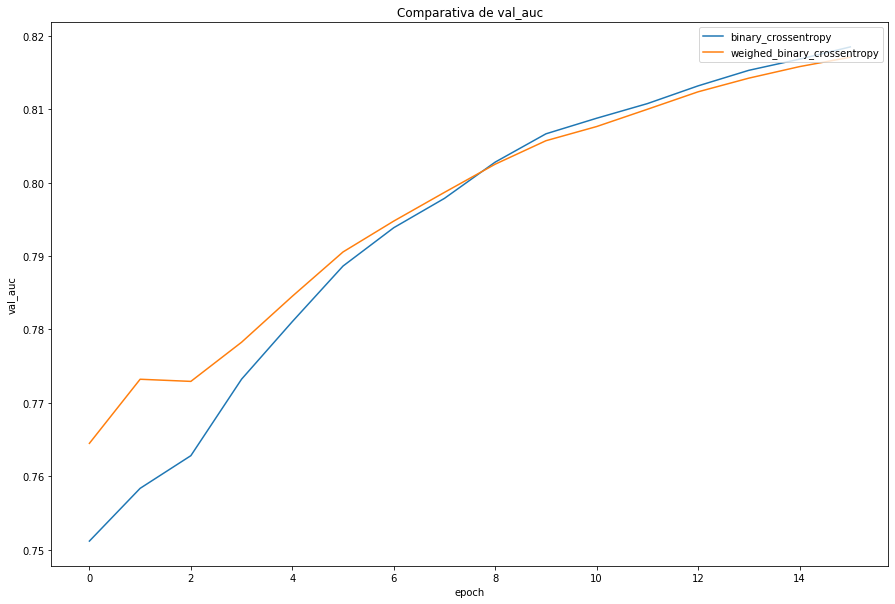

Max. val_auc binary_crossentropy: 0.8184903860092163
Max. val_auc weighed_binary_crossentropy:0.8170831799507141


In [19]:
results = {'binary_crossentropy' : res_binary_crossentropy[1], 'weighed_binary_crossentropy' : res_weighed_crossentropy[1]}
plot(results, metric='val_auc')

print('Max. val_auc binary_crossentropy: {}'.format(max(res_binary_crossentropy[1])))
print('Max. val_auc weighed_binary_crossentropy:{}'.format(max(res_weighed_crossentropy[1])))

A partir de la gráfica anterior se puede comprobar que no existe apenas diferencia entre ambas métricas. Se empleará weighed_binary_crossentropy. Si bien para el dataset reducido puede que no tenga mucha diferencia, es posible que sí la tenga cuando se repita el mismo análisis con el dataset completo en el que los datos son mucho más disperos, y la proporción de 0s es muy superior a la de 1s. 

## 5. Entrenamiento

En este apartado se probarán varias arquitecturas de redes pre-entrenadas disponibles con Keras. Estas redes permiten inicializar los valores a pesos entrenandos sobre ImageNet, por lo que permite beneficiarse del _transfer learning_ y poder congelar un número de capas iniciales ya pre-entrenadas para detectar las características más abstractas.

El entrenamiento se realiza en dos pasos:
1. Se congelan todas las capas del modelo pre-entrenado para entrenar únicamente las capas densas añadidas en la parte final de la red.
2. Se descongela un porcentaje de las últimas capas del modelo pre-entrenado y se repite el entrenamiento.

Todos los modelos entrenados se persisten junto a un ID para poder ser recuperados posteriormente en el apartado de evaluación. 

Para cada tipo de modelo se realiza un random search para encontrar los valores óptimos de los hiperparámetros. En todos ellos se emplea la sigmoid como función de activación en la capa de salida para poder obtener un valor entre 0 y 1 para todas las etiquetas. 

Los hiperparámetros que se prueban son:
* Tipo de poling: avg, max o sin pooling.
* Número de neurnas en la última capa densa: entre 128 y 512
* Porcentaje de capas iniciales a congelar: entre 50 y 80%. 

Se emplea Adam como optimizador para todos los modelos. No se ha hecho una comparativa con otros optimizadores. 

In [20]:
def build_InceptionV3(input_shape, params):
    base_model = InceptionV3(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_ResNet50(input_shape, params):
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_VGG16(input_shape, params):
    base_model = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_InceptionResNetV2(input_shape, params):
    base_model = InceptionResNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_DenseNet201(input_shape, params):
    base_model = DenseNet201(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model


A continuación se define el código para realizar un random search de los parámetros. Se realizará una exploración de N (20) combinaciones por cada arquitectura probada.

In [21]:
KERNEL_SIZE_PARAM = "kernel_size"
DROPOUT_PARAM = "dropout"
GLOBAL_POOLING_TYPE = "global_pooling_type"
DENSE_LAYER_SIZE_PARAM = 'dense_layer_size'
NUM_BLOCKS_PARAM = "num_blocks"
FIRST_CONV_LAYER_SIZE = "first_conv_layer_size"
ACTIVATION_FUNCTION = "activation_function"
OUTPUT_LAYER_SIZE = "output_layer_size"

N = 20

def freeze_all_layers(model):
    for layer in model.layers:
        layer.trainable = False

def try_pretrained_model(model_name, attr_type=None, activation_function = 'sigmoid', output_layer_size = NUM_CLASSES):
    results = pd.DataFrame(columns = [GLOBAL_POOLING_TYPE, DENSE_LAYER_SIZE_PARAM, 'freeze_layers_ratio', 'val_loss','val_auc', 'time'])
    for i in range(0, N):
        try:
            # Random search de los parámetros
            params = {}
            params[GLOBAL_POOLING_TYPE] = random.choice(['avg', 'max', None])
            params[DENSE_LAYER_SIZE_PARAM] = random.randrange(128,513,8)
            freeze_layers_ratio = random.choice([0.5, 0.6, 0.7, 0.8])
            
            # Definición de la función de activación para usar en la capa de salida
            params[ACTIVATION_FUNCTION] = activation_function
            params[OUTPUT_LAYER_SIZE] = output_layer_size
            
            print('Evaluation #{}'.format(i))
            start = time.time()
            
            # Llamada a la función de entrenamiento definida en apartados anteriores
            (val_loss, val_auc) = train(model_name, i, store_model=True, two_step_fit=True, 
                                        freeze_layers_ratio=freeze_layers_ratio, model_build_params=params, 
                                        attr_type=attr_type)
            end = time.time() - start
            
            # Acumulación de los resultados
            results.loc[i] = [params[GLOBAL_POOLING_TYPE], params[DENSE_LAYER_SIZE_PARAM], freeze_layers_ratio, val_loss, val_auc, end]
        except Exception as e:
            traceback.print_exc()
            print('Error: {}'.format(e))
            print('Error with params: {}'.format(params))
    return results

Lanzamos la búsqueda:

In [22]:
RESET = False
if(RESET):
    %cache -r results_inceptionV3
    %cache -r results_resnet50 
    %cache -r results_vgg16
    %cache -r results_inceptionResNetV2
    %cache -r results_densenet201    

%cache results_inceptionV3 = try_pretrained_model('InceptionV3')
%cache results_resnet50 = try_pretrained_model('ResNet50')
%cache results_vgg16 = try_pretrained_model('VGG16')
%cache results_inceptionResNetV2 = try_pretrained_model('InceptionResNetV2')
%cache results_densenet201 = try_pretrained_model('DenseNet201')

Loading cached value for variable 'results_inceptionV3'. Time since caching: 16:49:58.237080
Loading cached value for variable 'results_resnet50'. Time since caching: 14:41:43.706132
Loading cached value for variable 'results_vgg16'. Time since caching: 12:20:15.850144
Loading cached value for variable 'results_inceptionResNetV2'. Time since caching: 8:12:31.141850
Loading cached value for variable 'results_densenet201'. Time since caching: 3:03:16.488284


Definimos una función para ordenar los modelos generados en función del valor mínimo de loss sobre el conjunto de validación. El índice de la tabla representa el model_id con el que se ha persistido el modelo, para poder ser recuperado en la fase de evaluación. 

In [23]:
# Ordena todos los modelos en base al máximo accuracy conseguido.  
def sort_by_max_accuracy(df):
    df["min_val_loss"] = df.apply(lambda row: min(row['val_loss']), axis=1)
    df["val_auc"] = df.apply(lambda row: max(row['val_auc']), axis=1)
    df = df.drop(columns=['val_loss', 'val_auc'])
    return df.sort_values(by='min_val_loss', ascending=True).head(n=5)

Mostramos los resultados obtenidos para la arquitectura InceptionV3:

In [24]:
results_inceptionV3 = sort_by_max_accuracy(results_inceptionV3)
results_inceptionV3

,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss
16,avg,192,0.70,443.41,0.87
19,avg,472,0.80,359.38,0.88
13,avg,200,0.80,369.89,0.88
12,max,376,0.70,460.92,0.90
11,max,400,0.60,498.75,0.93


Mostramos los resultados obtenidos para la arquitectura ResNet50:

In [25]:
results_resnet50 = sort_by_max_accuracy(results_resnet50)
results_resnet50

,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss
10,None,192,0.60,521.01,1.11
4,max,160,0.70,464.56,1.21
5,avg,416,0.60,367.09,1.22
18,None,336,0.60,423.61,1.22
15,avg,160,0.50,476.18,1.24


Mostramos los resultados obtenidos para la arquitectura VGG16:

In [26]:
results_vgg16 = sort_by_max_accuracy(results_vgg16)
results_vgg16

,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss
0,max,512,0.80,438.70,0.70
6,avg,264,0.80,489.07,0.80
7,avg,216,0.80,597.26,0.80
16,None,384,0.80,333.97,0.82
1,None,432,0.80,456.92,0.83


In [27]:
results_inceptionResNetV2 = sort_by_max_accuracy(results_inceptionResNetV2)
results_inceptionResNetV2

,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss
18,avg,256,0.70,773.20,0.91
1,avg,248,0.60,836.51,0.94
17,avg,216,0.50,812.43,0.96
9,avg,496,0.70,820.96,0.99
16,avg,136,0.50,971.08,1.00


In [28]:
results_densenet201 = sort_by_max_accuracy(results_densenet201)
results_densenet201

,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss
19,avg,456,0.50,996.57,0.83
2,max,328,0.60,915.08,0.85
4,max,160,0.50,"1,221.57",0.85
6,avg,240,0.60,"1,247.95",0.85
10,max,408,0.60,"1,048.48",0.85


## 6. Evaluación

En este apartado se realizará la evaluación de las versiones de cada una de las arquitecturas probadas en el apartado anterior con el que se han obtenido mejores resultados. Se empleará aquellas versiones que minimizan el loss sobre el conjunto de validación. 

Se calculará la metríca de top-k recall para establecer la comparativa, tal y como se describe en la memoria del trabajo. Se emplearán valores de k = 3, 5, 6. En el caso de esta versión del conjunto de datos en el que sabemos a priori que todas las observaciones tienen 6 etiquetas asociadas, nos basaremos en el valor k=6 para decidir con qué modelo se obtienen los mejores resultados. 

In [29]:
# Cálculo de top-k recall
def top_k_recall(k, y_pred, y_true_df):
    correctly_annotated = [0] * NUM_CLASSES
    ground_truth = [0] * NUM_CLASSES
        
    # Itearción de etiquetas del conjunto de test
    for index, row in y_true_df.iterrows():
        true_possitives = np.where(row==1)
        for i in true_possitives[0]:
            ground_truth[i]+=1
        
        predicted_k_values = np.argpartition(y_pred[index], -k)[-k:]
        for p in predicted_k_values:
            if p in true_possitives[0]:
                correctly_annotated[p]+=1
        
    # print(num_correctly_annotated)
    # print(ground_truth)
    return sum(correctly_annotated)/sum(ground_truth)
        
# Evaluación de un modelo.     
def evaluate(model_name, model_id, attr_type=None):
    # Forzar limpieza y pasar el GC
    K.clear_session()
    gc.collect()

    # Recuperar el modelo guardado
    model = load_model(to_model_path(model_name, model_id), compile = False)
    model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=[tf.keras.metrics.AUC(name='auc')])
    
    # Generator de datos de test
    test_generator = build_test_generator(attr_type)
    
    # Predicción
    y_pred = model.predict_generator(test_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1) 

    # Carga de las etiquetas del conjunto de test
    partition_attribute_filepath = ANNO_FINE_PATH + "/test_attr.txt"
    y_true_df = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)
    
    results = {}
    results[3] = top_k_recall(3, y_pred, y_true_df)
    results[5] = top_k_recall(5, y_pred, y_true_df)
    results[6] = top_k_recall(6, y_pred, y_true_df)
    
    return (y_pred, results)

Recuperamos el ID para cada uno de los modelos con el valor mínimo de loss sobre el conjunto de validación, y lanzamos la evaluación:

In [30]:
RESET = False
if(RESET):
    %cache -r inceptionV3_test_res
    %cache -r resnet50_test_res
    %cache -r vgg16_test_res 
    %cache -r inceptionResNetV2_test_res 
    %cache -r densenet201_test_res 
    
%cache inceptionV3_test_res = evaluate('InceptionV3', model_id = results_inceptionV3.iloc[0].name)
%cache resnet50_test_res = evaluate('ResNet50',model_id = results_resnet50.iloc[0].name)
%cache vgg16_test_res = evaluate('VGG16', model_id = results_vgg16.iloc[0].name)
%cache inceptionResNetV2_test_res = evaluate('InceptionResNetV2', model_id = results_inceptionResNetV2.iloc[0].name)
%cache densenet201_test_res = evaluate('DenseNet201', model_id = results_densenet201.iloc[0].name)

Loading cached value for variable 'inceptionV3_test_res'. Time since caching: 3:02:29.182422
Loading cached value for variable 'resnet50_test_res'. Time since caching: 3:01:19.688717
Loading cached value for variable 'vgg16_test_res'. Time since caching: 3:00:31.877660
Loading cached value for variable 'inceptionResNetV2_test_res'. Time since caching: 2:58:58.758541
Loading cached value for variable 'densenet201_test_res'. Time since caching: 2:56:44.569973


In [31]:
list_of_lists = []
list_of_lists.append(inceptionV3_test_res[1].values())
list_of_lists.append(resnet50_test_res[1].values())
list_of_lists.append(vgg16_test_res[1].values())
list_of_lists.append(inceptionResNetV2_test_res[1].values())
list_of_lists.append(densenet201_test_res[1].values())

pd.DataFrame(list_of_lists, columns=['top-3 recall', 'top-5 recall', 'top-6 recall'], 
             index=['InceptionV3', 'ResNet50', 'VGG16', 'InceptionResNetV2', 'DenseNet201'])


,top-3 recall,top-5 recall,top-6 recall
InceptionV3,0.42,0.63,0.72
ResNet50,0.37,0.53,0.60
VGG16,0.43,0.65,0.74
InceptionResNetV2,0.39,0.58,0.67
DenseNet201,0.42,0.63,0.71


# 7. Análisis de los resultados

En este apartado se realizará un análisis de los resultados del modelo con el que se han obtenido mejores resultados en el apartado anterior en la métrica de top-6 recall. 

Para el conjunto de etiquetas predichas, se recupera las 6 etiquetas que mayor probabilidad tienen en la respuesta del modelo. Se emplea este valor puesto que se sabe a priori que el conjunto de etiquetas real está formado por 6 elementos. Cuando se realice este procedimiento sobre el conjunto de datos completo en el que el número de etiquetas real es variable, se recuperarán aquellas cuyo valor de predicción supere un umbral por definir. 

In [32]:
# Muestra N ejemplos de la partición de test con sus etiquetas reales y las etiquetas predichas
# Para las etiquetas predichas, recupera las k etiquetas con mayor probabilidad. 
def display_examples(y_pred, k=6, n=5):
    for index, row in build_iterator_dataframe('test').iterrows():
        
        # Mostrar imagen
        img = load_img('{}/{}'.format(TEST_PATH, row['filename']))
        plt.title('Ejemplo: {}'.format(index+1))
        plt.imshow(img)
        plt.show()
        
        # Recuperar las etiquetas reales
        true_labels = [column_to_attr_name[i] for i in np.where(row==1)[0]]
        true_labels.sort()
        
        # Recuperar las k etiquetas con mayor probabilidad
        predicted_k_values = np.argpartition(y_pred[index], -k)[-k:]
        predicted_labels = [column_to_attr_name[i] for i in predicted_k_values]
        predicted_labels.sort()
        
        print('True labels: ' + str(true_labels))
        print('Predicted labels: ' + str(predicted_labels))
        
        if(n == index+1):
            return  

./data/anno_fine/test_attr.txt


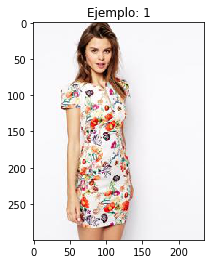

True labels: ['cotton', 'crew_neckline', 'floral', 'mini_length', 'short_sleeve', 'tight']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'floral', 'mini_length', 'short_sleeve']


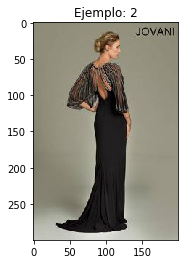

True labels: ['chiffon', 'conventional', 'long_sleeve', 'no_dress', 'no_neckline', 'pleated']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'no_dress', 'short_sleeve', 'solid']


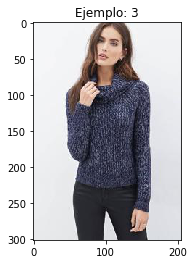

True labels: ['conventional', 'crew_neckline', 'knit', 'long_sleeve', 'no_dress', 'solid']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'long_sleeve', 'no_dress', 'solid']


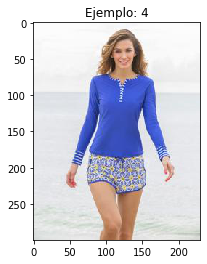

True labels: ['conventional', 'cotton', 'floral', 'no_dress', 'no_neckline', 'sleeveless']
Predicted labels: ['conventional', 'cotton', 'no_dress', 'no_neckline', 'sleeveless', 'solid']


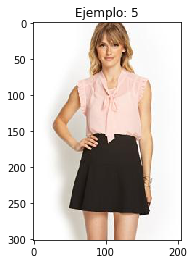

True labels: ['chiffon', 'conventional', 'no_dress', 'sleeveless', 'solid', 'v_neckline']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'no_dress', 'solid', 'v_neckline']


In [33]:
# Ejemplos para la red DenseNet201
y_pred_vgg16 = vgg16_test_res[0]
display_examples(y_pred_vgg16)

In [34]:
# Calcula
## Número de veces que aparece un atributo en una predicción
## Número de veces en el que la predicción de un atributo se realiza de forma correcta
## Número de veces en el que la predicción de un atributo se realiza de forma incorrecta
def get_prediction_accuracy(y_true_df, y_pred, k=6):
    
    # Inicialización de los vectores
    times_predicted = [0] * NUM_CLASSES
    times_correctly_predicted = [0] * NUM_CLASSES
    times_incorrectly_predicted = [0] * NUM_CLASSES

    for index, row in y_true_df.iterrows():
        
        # Obtención de los verdaderos positivos
        true_possitives = np.where(row==1)

        # Obtención de los k valores con mayor probabilidad
        predicted_k_values = np.argpartition(y_pred[index], -k)[-k:]
        for p in predicted_k_values:
            
            # Clasificación
            times_predicted[p]+=1
            if p in true_possitives[0]:
                times_correctly_predicted[p]+=1
            else:
                times_incorrectly_predicted[p]+=1
    return times_predicted, times_correctly_predicted, times_incorrectly_predicted

In [35]:
# Construcción de la tabla de resultados a partir de la lista de listas de valores predichos por un modelo sobre la partición de test
def build_results_table(y_pred):

    # Carga de las anotaciones reales de la partición de test
    partition_attribute_filepath = ANNO_FINE_PATH + "/test_attr.txt"
    y_true_df = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)

    # Columna de tipo de atributo
    attr_types = []
    for k, v in attr_type_to_columns.items():
        attr_types.extend([ATTR_TYPES[str(k)]] * len(v))

    # Columna de frecuencia real
    frequency = y_true_df.sum().tolist()

    # Columna de frecuencia de predicción, Verdaderos positivos y Falsos positivos
    times_predicted, times_correctly_predicted, times_incorrectly_predicted = get_prediction_accuracy(y_true_df, y_pred)

    # Columnas de sensibilidad y precisión
    recall = [a/b for a,b in zip(times_correctly_predicted, frequency)]
    precission = [a/max(1,b) for a,b in zip(times_correctly_predicted, times_predicted)]

    # Creación de dataframe
    d = {'Atributo': attributes, 'Tipo': attr_types, 'Frecuencia real' : frequency, 
         'Frecuencia predicción' : times_predicted, 'TP': times_correctly_predicted, 'FP' : times_incorrectly_predicted, 
         'Sensibilidad' : recall, 'Precisión' : precission}
    return pd.DataFrame(data=d)


In [36]:
build_results_table(y_pred_vgg16)

,Atributo,Tipo,Frecuencia real,Frecuencia predicción,TP,FP,Sensibilidad,Precisión
0,floral,Estampado,664,659,408,251,0.61,0.62
1,graphic,Estampado,668,407,253,154,0.38,0.62
2,striped,Estampado,292,237,175,62,0.60,0.74
3,embroidered,Estampado,338,0,0,0,0.00,0.00
4,pleated,Estampado,78,0,0,0,0.00,0.00
5,solid,Estampado,1898,2345,1698,647,0.89,0.72
6,lattice,Estampado,62,0,0,0,0.00,0.00
7,long_sleeve,Tipo de manga,1243,1397,1060,337,0.85,0.76
8,short_sleeve,Tipo de manga,686,450,352,98,0.51,0.78
9,sleeveless,Tipo de manga,2071,2166,1831,335,0.88,0.85


A partir de la tabla anterior se puede observar que la mayor problemática a la hora de entrenar el modelo ha sido el _data imbalace_. Los atributos que aparecen con mayor frecuencia (tanto en las particiones de entrenamiento y validación, como en la de test) suelen predecirse con mayor frecuencia que los atributos minoritarios. Esto implica que atribotos como _leather_ o _faux_ no aparezcan en ninga predicción. Por otro lado llama la atención el bajo número de veces que el modelo predice atributos como _knit_ o _embroidered_. 

En una iteración posterior sobre estos modelos se podría contemplar aumentar el número de ejemplos de los atributos minoritarios en las particiones de entrenamiento y validación, o el empleo de alguna métrica como F1 a la hora de realizar el entrenamiento para solventar este problema. 

Por otro lado, en los casos en los que en una imagen aparecen varias prendas, se ha detectado que las anotaciones pertenecen a una de ellas mientras que el modelo parece predecir las de otra. Esto se puede apreciar en el ejemplo 4, en el que solo hay una diferencia en el conjunto de etiquetas. La etiqueta real es _floral_, que aplica al pantalón corto mientras que el modelo predice _solid_ que aplica a la prenda superior. 

# Clasificador por tipo de atributo

In [37]:
build_iterator_dataframe('test', 1)

./data/anno_fine/test_attr.txt


,floral,graphic,striped,embroidered,pleated,solid,lattice,filename
0,1,0,0,0,0,0,0,0.jpg
1,0,0,0,0,1,0,0,1.jpg
2,0,0,0,0,0,1,0,2.jpg
3,1,0,0,0,0,0,0,3.jpg
4,0,0,0,0,0,1,0,4.jpg
...,...,...,...,...,...,...,...,...
3995,1,0,0,0,0,0,0,3995.jpg
3996,1,0,0,0,0,0,0,3996.jpg
3997,0,0,0,0,0,1,0,3997.jpg
3998,0,0,1,0,0,0,0,3998.jpg


In [40]:
def try_pretrained_models_per_attribute_type():
    res = {}
    for attr_type in range(1,7):
        output_layer_size = len(attr_type_to_columns[str(attr_type)])
        
        res_attr_type = {}
        res[attr_type] = res_attr_type
        for architecture in ['InceptionV3', 'ResNet50', 'VGG16', 'InceptionResNetV2', 'DenseNet201']:
            print('$$$: Starting with attribute type {} and architecture {}'.format(attr_type, architecture))
            res_attr_type[architecture] = try_pretrained_model(architecture, attr_type, 'softmax', output_layer_size)
    return res


In [41]:
%cache results_per_attr_type = try_pretrained_models_per_attribute_type()

Creating new value for variable 'results_per_attr_type'
$$$: Starting with attribute type 1 and architecture InceptionV3
Evaluation #0
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
49/50 [============================>.] - ETA: 0s - loss: 2.7845 - auc: 0.7409

KeyboardInterrupt: 

Error: There was an error during the execution of the expression. No value will be stored. The Expression was: 
results_per_attr_type = try_pretrained_models_per_attribute_type()
